In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
%matplotlib inline

In [9]:
tf.random.set_seed(42)

## Get Data Directories

In [10]:
train_dir = "/kaggle/input/indian-sign-language-dataset/data"

# Custom CNN

## Creating Data Generators

In [11]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2, 
                                   zoom_range=0.2, 
                                   horizontal_flip=True,
                                   featurewise_center=True,
                                   featurewise_std_normalization=True,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   validation_split=0.2)
valid_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

## Flow from directory

In [12]:
train_data = train_datagen.flow_from_directory(train_dir, 
                                               target_size=(224, 224), 
                                               color_mode='rgb',
                                               batch_size=32, 
                                               class_mode='categorical',
                                               shuffle=True,
                                               subset = 'training') 

valid_data = valid_datagen.flow_from_directory(train_dir, 
                                           target_size=(224, 224), 
                                           color_mode='rgb',
                                           batch_size=32, 
                                           class_mode='categorical',
                                           shuffle=False,
                                           subset = 'validation')

Found 33600 images belonging to 35 classes.
Found 8400 images belonging to 35 classes.


## Model Architecture

In [13]:
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu", input_shape=(224, 224, 3), strides=2),
    tf.keras.layers.Conv2D(32, 3, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=2, padding="valid"),
    tf.keras.layers.Conv2D(32, 3, activation="relu", strides=2),
    tf.keras.layers.Conv2D(24, 3, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=2, padding="valid"),
    tf.keras.layers.Conv2D(24, 3, activation="relu", strides=2),
    tf.keras.layers.Conv2D(16, 3, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=2, padding="valid"),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.05)),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.05)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(35, activation="softmax")
])

In [14]:
model_1.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=["accuracy"])
model_1.fit(train_data, epochs=100, steps_per_epoch=len(train_data), validation_data=valid_data, validation_steps=len(valid_data), callbacks=[tf.keras.callbacks.EarlyStopping(min_delta=0.01, patience=2)])

Epoch 1/100
1050/1050 [==============================] - 486s 462ms/step - loss: 7.1391 - accuracy: 0.0935 - val_loss: 4.2687 - val_accuracy: 0.2440
Epoch 2/100
1050/1050 [==============================] - 416s 396ms/step - loss: 3.3137 - accuracy: 0.3317 - val_loss: 2.0952 - val_accuracy: 0.6968
Epoch 3/100
1050/1050 [==============================] - 412s 392ms/step - loss: 2.1676 - accuracy: 0.5890 - val_loss: 1.4160 - val_accuracy: 0.9090
Epoch 4/100
1050/1050 [==============================] - 401s 381ms/step - loss: 1.6979 - accuracy: 0.7276 - val_loss: 1.1475 - val_accuracy: 0.9331
Epoch 5/100
1050/1050 [==============================] - 404s 384ms/step - loss: 1.4231 - accuracy: 0.8060 - val_loss: 0.9520 - val_accuracy: 0.9655
Epoch 6/100
1050/1050 [==============================] - 411s 392ms/step - loss: 1.2298 - accuracy: 0.8601 - val_loss: 0.8658 - val_accuracy: 0.9692
Epoch 7/100
1050/1050 [==============================] - 409s 389ms/step - loss: 1.0812 - accuracy: 0.8911

In [15]:
history = model_1.history

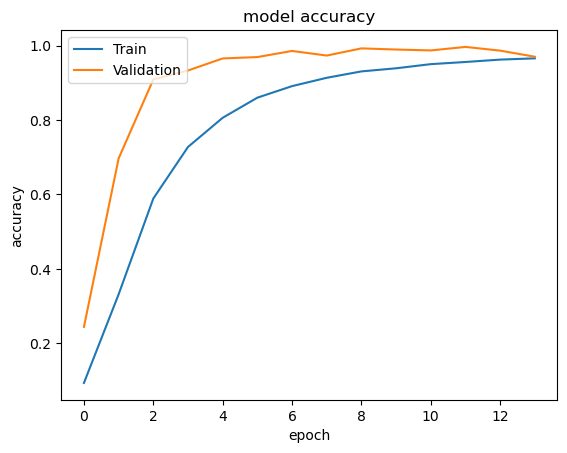

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig("resenet50_with_augmentation.png")
plt.show()

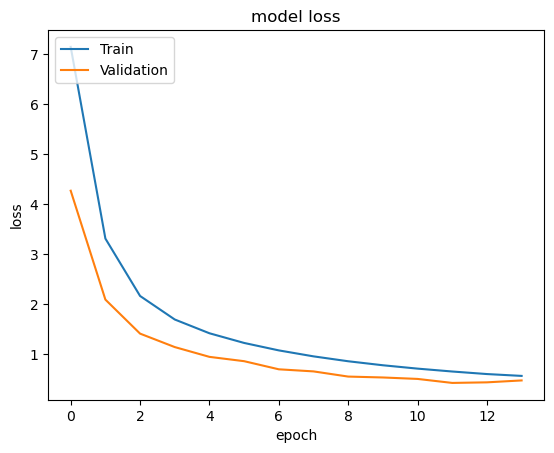

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig("resenet50_with_augmentation_loss.png")
plt.show()

In [18]:
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 111, 111, 32)      896       
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 batch_normalization_3 (Batc  (None, 109, 109, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 26, 26, 32)        9248      
                                                                 
 conv2d_9 (Conv2D)           (None, 24, 24, 24)       

In [19]:
model_1.save("model_1_aug.h5")

# Using Transfer Learning

## Getting ResNet50

In [20]:
resnet_model = tf.keras.applications.ResNet50(weights='imagenet', 
                                              include_top=False, 
                                              input_shape=(224, 224, 3), 
                                              classes=35, 
                                              pooling="avg"
                                             )

94765736/94765736 [==============================] - 0s 0us/step


In [21]:
input_shape = (1, 224, 224, 3)

In [22]:
for layer in resnet_model.layers[:143]:
    layer.trainable = False

In [23]:
tl_model_1 = tf.keras.models.Sequential()
tl_model_1.add(resnet_model)
tl_model_1.add(tf.keras.layers.Dropout(0.5))
tl_model_1.add(tf.keras.layers.Dense(35, activation="softmax"))

In [24]:
tl_model_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 35)                71715     
                                                                 
Total params: 23,659,427
Trainable params: 15,047,715
Non-trainable params: 8,611,712
_________________________________________________________________


In [25]:
check_point = tf.keras.callbacks.ModelCheckpoint(filepath="model_checkpoint.h5",
                                                 monitor="val_accuracy",
                                                 mode='max',
                                                 save_best_only = True
                                                )

In [26]:
tl_model_1.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=["accuracy"])
tl_model_1.fit(train_data, epochs=10, steps_per_epoch=len(train_data), validation_data=valid_data, validation_steps=len(valid_data), callbacks=[tf.keras.callbacks.EarlyStopping(min_delta=0.01, patience=2)])

Epoch 1/10
1050/1050 [==============================] - 433s 408ms/step - loss: 0.8864 - accuracy: 0.7351 - val_loss: 2.3085 - val_accuracy: 0.6043
Epoch 2/10
1050/1050 [==============================] - 427s 406ms/step - loss: 0.1705 - accuracy: 0.9489 - val_loss: 0.3867 - val_accuracy: 0.8595
Epoch 3/10
1050/1050 [==============================] - 438s 417ms/step - loss: 0.0966 - accuracy: 0.9706 - val_loss: 0.2460 - val_accuracy: 0.9307
Epoch 4/10
1050/1050 [==============================] - 443s 422ms/step - loss: 0.0775 - accuracy: 0.9772 - val_loss: 0.0637 - val_accuracy: 0.9779
Epoch 5/10
1050/1050 [==============================] - 430s 409ms/step - loss: 0.0592 - accuracy: 0.9825 - val_loss: 0.0090 - val_accuracy: 0.9992
Epoch 6/10
1050/1050 [==============================] - 432s 412ms/step - loss: 0.0493 - accuracy: 0.9857 - val_loss: 0.0154 - val_accuracy: 0.9944
Epoch 7/10
1050/1050 [==============================] - 445s 424ms/step - loss: 0.0429 - accuracy: 0.9872 - val_

In [27]:
tl_model_1.save("tl_model_1.h5")

In [28]:
history = tl_model_1.history

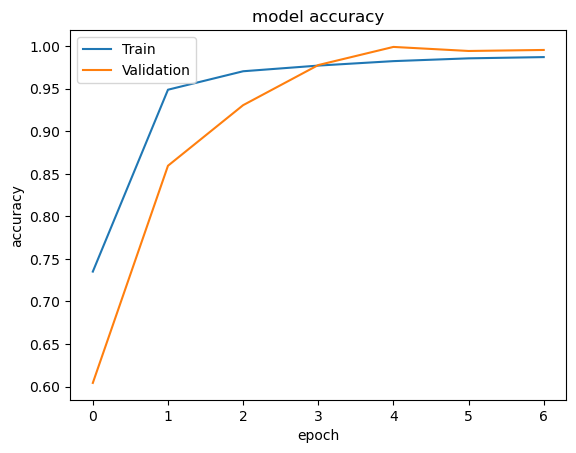

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig("resenet50_with_augmentation.png")
plt.show()

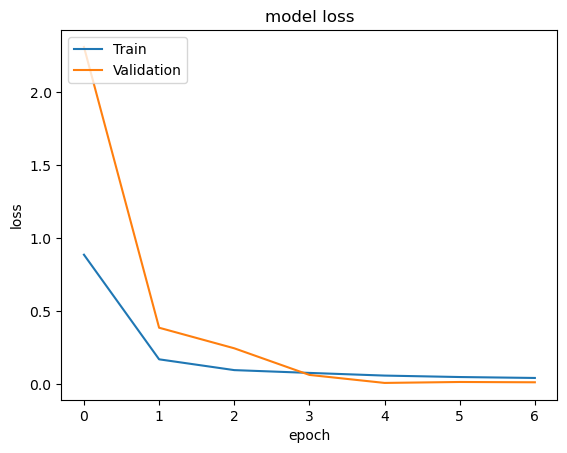

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig("resenet50_with_augmentation_loss.png")
plt.show()

## Using `image_dataset_from_directory`

In [31]:
train_datagen = tf.keras.utils.image_dataset_from_directory(train_dir, shuffle=True, subset="training", label_mode="categorical", batch_size=32, image_size=(224, 224), validation_split=0.3, seed=42)
valid_datagen = tf.keras.utils.image_dataset_from_directory(train_dir, shuffle=True, subset="validation", label_mode="categorical", batch_size=32, image_size=(224, 224), validation_split=0.3, seed=42)

Found 42000 files belonging to 35 classes.
Using 29400 files for training.
Found 42000 files belonging to 35 classes.
Using 12600 files for validation.


In [32]:
train_datagen

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 35), dtype=tf.float32, name=None))>

In [33]:
train_datagen.class_names

['1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z']

In [34]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomWidth(0.2),
    tf.keras.layers.Rescaling(1./255),
], name="data_augmentation")

In [35]:
resnet_model = tf.keras.applications.ResNet50(weights='imagenet', 
                                              include_top=False, 
                                              input_shape=(224, 224, 3), 
                                              classes=35,
                                             )
for layer in resnet_model.layers[:143]:
    layer.trainable = False

In [36]:
inputs = tf.keras.layers.Input(shape = (224, 224, 3), name="input_layer")

x = data_augmentation(inputs)

x = resnet_model(x, training = False)

x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.GlobalAveragePooling2D()(x)

outputs = tf.keras.layers.Dense(35, activation="softmax", name="output_layer")(x)

tl_model_2 = tf.keras.Model(inputs, outputs)

In [37]:
tl_model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
               metrics=["accuracy"])

tl_model_2.fit(train_datagen, epochs=40, steps_per_epoch=len(train_datagen), validation_data=valid_datagen, validation_steps=int(0.25 * len(valid_datagen)), callbacks=[tf.keras.callbacks.TensorBoard(log_dir='./logs/'), tf.keras.callbacks.EarlyStopping(min_delta=0.01, patience=3)])

Epoch 1/40
919/919 [==============================] - 351s 376ms/step - loss: 2.6897 - accuracy: 0.2113 - val_loss: 1.6284 - val_accuracy: 0.4464
Epoch 2/40
919/919 [==============================] - 223s 242ms/step - loss: 1.2409 - accuracy: 0.6341 - val_loss: 1.7132 - val_accuracy: 0.4770
Epoch 3/40
919/919 [==============================] - 201s 219ms/step - loss: 0.4509 - accuracy: 0.8748 - val_loss: 0.9257 - val_accuracy: 0.6878
Epoch 4/40
919/919 [==============================] - 193s 209ms/step - loss: 0.1901 - accuracy: 0.9514 - val_loss: 1.2723 - val_accuracy: 0.6186
Epoch 5/40
919/919 [==============================] - 193s 209ms/step - loss: 0.1120 - accuracy: 0.9722 - val_loss: 0.3449 - val_accuracy: 0.8903
Epoch 6/40
919/919 [==============================] - 186s 203ms/step - loss: 0.0866 - accuracy: 0.9774 - val_loss: 0.0560 - val_accuracy: 0.9799
Epoch 7/40
919/919 [==============================] - 188s 204ms/step - loss: 0.0758 - accuracy: 0.9796 - val_loss: 0.0703 -

In [38]:
tl_model_2.save("tl_model_2.h5")

In [39]:
history = tl_model_2.history

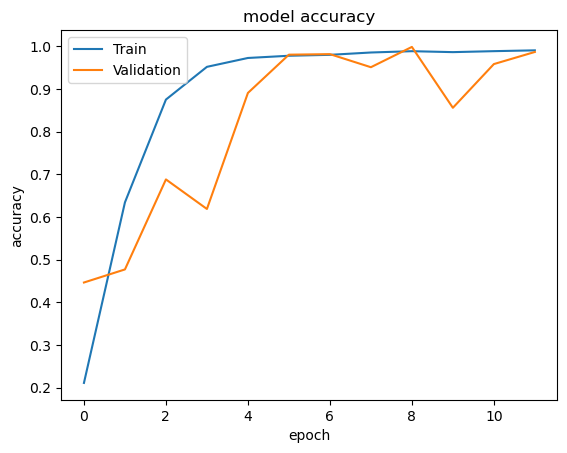

In [40]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig("resenet50_with_augmentation2.png")
plt.show()

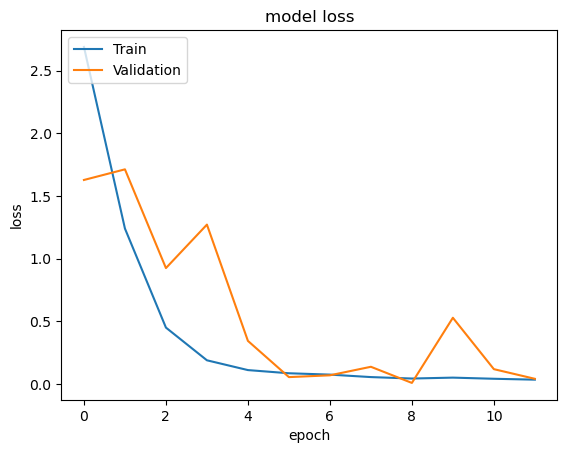

In [41]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig("resenet50_with_augmentation_loss2.png")
plt.show()